# FQI on Car On Hill

## Define parameters

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import jax
import jax.numpy as jnp
import os
import json

parameters = json.load(open("parameters.json"))
env_seed = parameters["env_seed"]
gamma = parameters["gamma"]

# Sample collection
oriented_state = jnp.array(parameters["oriented_state"])
n_random_samples = parameters["n_random_samples"]
n_oriented_samples = parameters["n_oriented_samples"]
n_samples = n_random_samples + n_oriented_samples

# Trainings
layers_dimension = parameters["layers_dimension"]
max_bellman_iterations = parameters["max_bellman_iterations"]
batch_size_samples = n_samples
fitting_steps = 1200
learning_rate = {"first": 0.001, "last": 0.00001, "duration": fitting_steps * n_samples // batch_size_samples}
max_patience = parameters["max_patience"]

# Visualisation of errors and performances
n_states_x = parameters["n_states_x"]
n_states_v = parameters["n_states_v"]
horizon = parameters["horizon"]

# Search for an unused seed
max_used_seed = 0
for file in os.listdir("figures/data/FQI/"):
    if int(file.split("_")[0]) == max_bellman_iterations and int(file.split("_")[2][:-4]) > max_used_seed:
        max_used_seed = int(file.split("_")[2][:-4])
max_used_seed

# keys
seed = max_used_seed + 1
sample_key = jax.random.PRNGKey(env_seed)
key = jax.random.PRNGKey(seed)
shuffle_key, q_network_key, _, _ = jax.random.split(key, 4) # 4 keys are generated to be coherent with the other trainings

## Define environment

In [2]:
import numpy as np

from pbo.environment.car_on_hill import CarOnHillEnv


max_pos = 1.0
max_velocity = 3.0

states_x = jnp.linspace(-max_pos, max_pos, n_states_x)
boxes_x_size = (2 * max_pos) / (n_states_x - 1)
states_x_boxes = (np.linspace(-max_pos, max_pos + boxes_x_size, n_states_x + 1) - boxes_x_size / 2)
states_v = jnp.linspace(-max_velocity, max_velocity, n_states_v)
boxes_v_size = (2 * max_velocity) / (n_states_v - 1)
states_v_boxes = (np.linspace(-max_velocity, max_velocity + boxes_v_size, n_states_v + 1) - boxes_v_size / 2)


env = CarOnHillEnv(max_pos, max_velocity, gamma)

## Collect samples

### Samples on the mesh and with a uniform policy

In [3]:
from pbo.sample_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

env.reset()
n_episodes = 0
n_steps = 0
for idx_sample in range(n_random_samples):
    state = env.state
    
    sample_key, key = jax.random.split(sample_key)
    if jax.random.uniform(key) > 0.5:
        action = jnp.array([0])
    else:
        action = jnp.array([1])
    next_state, reward, absorbing, _ = env.step(action)
    n_steps += 1

    replay_buffer.add(state, action, reward, next_state, absorbing)

    if absorbing or n_steps > horizon:
        env.reset()
        n_episodes += 1
        n_steps = 0


env.reset(oriented_state)
n_episodes += 1
n_steps = 0
for idx_sample in range(n_oriented_samples):
    state = env.state
    
    sample_key, key = jax.random.split(sample_key)
    if jax.random.uniform(key) > 0.5:
        action = jnp.array([0])
    else:
        action = jnp.array([1])
    next_state, reward, absorbing, _ = env.step(action)
    n_steps += 1

    replay_buffer.add(state, action, reward, next_state, absorbing)

    if absorbing or n_steps > horizon:
        sample_key, key = jax.random.split(sample_key)
        env.reset(jax.random.normal(key, (2,)) / 2 + oriented_state)

        n_episodes += 1
        n_steps = 0

replay_buffer.cast_to_jax_array()
assert sum(replay_buffer.rewards == 1) > 0, "No positive reward has been sampled, please do something!"
print(f"Number of episodes: {n_episodes}")

Number of episodes: 96


In [4]:
replay_buffer.actions[(replay_buffer.rewards == 1).flatten()]

DeviceArray([[1],
             [1],
             [0],
             [1],
             [0],
             [1],
             [0],
             [1],
             [0],
             [0],
             [1],
             [1],
             [0]], dtype=int32)

### Visualize samples

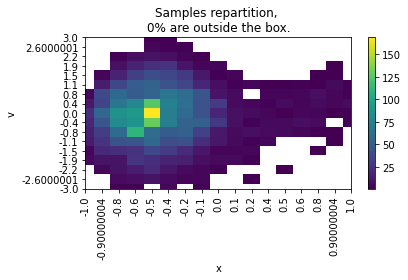

In [5]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh


samples_count, n_outside_boxes, rewards_count = count_samples(replay_buffer.states[:, 0], replay_buffer.states[:, 1], states_x_boxes, states_v_boxes, replay_buffer.rewards)
samples_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0, axis_equal=False)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel="x", ylabel="v"
)

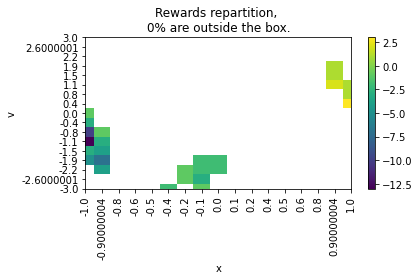

In [6]:
samples_visu_mesh.set_values(rewards_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Rewards repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel="x", ylabel="v"
)

## Train FQI

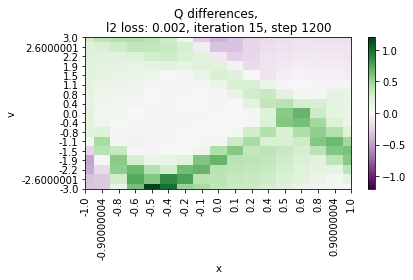

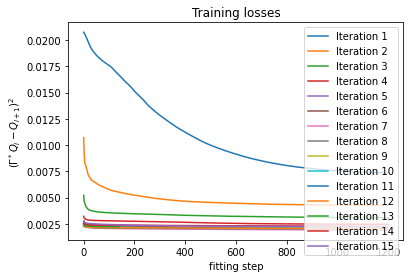

In [7]:
import matplotlib.pyplot as plt

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import FullyConnectedQ


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
q = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=2,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=None,
    learning_rate=learning_rate,
    layers_dimension=layers_dimension,
    zero_initializer=True,
)
iterated_q = np.zeros((max_bellman_iterations + 1, n_states_x, n_states_v, 2))
iterated_v = np.zeros((max_bellman_iterations + 1, n_states_x, n_states_v))

iterated_q[0] = env.q_mesh(q, states_x, states_v)
iterated_v[0] = env.v_mesh(q, horizon, states_x, states_v)

q_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0, axis_equal=False, zero_centered=True)
l2_losses = np.ones((max_bellman_iterations, fitting_steps)) * np.nan

for bellman_iteration in range(1, max_bellman_iterations + 1):
    q.reset_optimizer()
    params_target = q.params
    best_loss = float('inf')
    patience = 0

    for step in range(fitting_steps):
        cumulative_l2_loss = 0
        
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            q.params, q.optimizer_state, l2_loss = q.learn_on_batch(q.params, params_target, q.optimizer_state, batch_samples)
            cumulative_l2_loss += l2_loss

        l2_losses[bellman_iteration - 1, step] = cumulative_l2_loss
        if cumulative_l2_loss < best_loss:
            patience = 0
            best_loss = cumulative_l2_loss
        else:
            patience += 1

        if patience > max_patience:
            break

    diff_q = env.diff_q_mesh(q, states_x, states_v)

    q_visu_mesh.set_values(diff_q)
    q_visu_mesh.show(f"Q differences, \nl2 loss: {str(jnp.round(cumulative_l2_loss, 3))}, iteration {bellman_iteration}, step {step + 1}", xlabel="x", ylabel="v")

    iterated_q[bellman_iteration] = env.q_mesh(q, states_x, states_v)
    iterated_v[bellman_iteration] = env.v_mesh(q, horizon, states_x, states_v)

for bellman_iteration in range(0, max_bellman_iterations, max(max_bellman_iterations // 10, 1)):
    plt.plot(l2_losses[bellman_iteration], label=f"Iteration {bellman_iteration + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$(\Gamma^*Q_i - Q_{i +  1})^2$")
plt.title("Training losses")
plt.show()

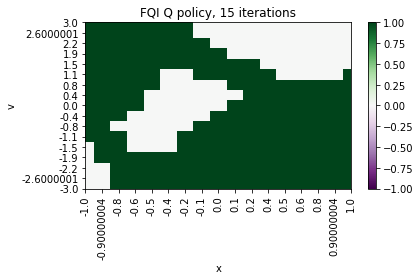

In [8]:
bellman_iteration = -1

q_visu_mesh.set_values((iterated_q[bellman_iteration, :, :, 1] > iterated_q[bellman_iteration, :, :, 0]).astype(float))
q_visu_mesh.show(f"FQI Q policy, {max_bellman_iterations} iterations", xlabel="x", ylabel="v")

In [9]:
# env.simulate(q, horizon, jnp.array([-0.5, 0]))

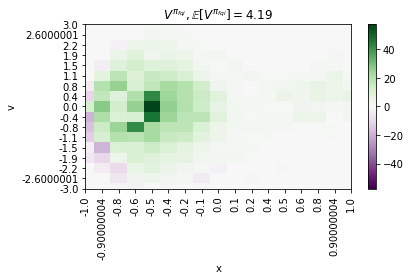

In [10]:
final_v = env.v_mesh(q, horizon, states_x, states_v)

average_performance = final_v * samples_count

q_visu_mesh.set_values(average_performance)
q_visu_mesh.show(r"$V^{\pi_{fqi}}, \mathbb{E}\left[ V^{\pi_{fqi}} \right] =$" + str(np.round(np.mean(average_performance), 2)), xlabel="x", ylabel="v")

## Save the data

In [11]:
np.save(f"figures/data/FQI/{max_bellman_iterations}_Q_{seed}.npy", iterated_q)
np.save(f"figures/data/FQI/{max_bellman_iterations}_V_{seed}.npy", iterated_v)